# DualCellQuant バッチ処理 (Step-by-Step)

大量の顕微鏡画像を連続処理するためのノートブック

## 処理フロー
1. 画像ファイルの読み込み
2. Cellpose-SAM セグメンテーション
3. Target/Reference マスク適用
4. 定量化 (Quantification)
5. Radial Profile 解析
6. Peak Difference 解析

## 1. セットアップ

In [ ]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm



# DualCellQuantモジュールをインポート
# testディレクトリから1つ上の階層のdualcellquantパッケージをインポート
parent_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from dualcellquant.core import (
    run_segmentation,
    apply_mask,
    integrate_and_quantify,
)
from dualcellquant.radial import (
    radial_mask,
    radial_profile_all_cells,
    compute_radial_peak_difference,
)
from dualcellquant.tracking import (
    relabel_to_previous,
)
from dualcellquant.visualization import (
    plot_radial_profile_with_peaks,
)

print("セットアップ完了")
print(f"DualCellQuantパス: {parent_dir}")


セットアップ完了
DualCellQuantパス: e:\Data\App\Python\dualCellQuant


In [2]:
# Jupyter Notebookでmatplotlibを表示するための設定
%matplotlib inline

## 2. パラメータ設定

In [3]:



# ========== セグメンテーションパラメータ ==========
SEG_PARAMS = {
    'source': 'reference',  # 'target' or 'reference'
    'channel': 'gray',   # 'gray', 'R', 'G', 'B'
    'diameter': 100,       # 0 = auto
    'flow_threshold': 0.4,
    'cellprob_threshold': 1,
    'use_gpu': True,
    # New: edge-touching 除外の制御
    'drop_edge_cells': True,
    'inside_fraction_min': 0.98,  # 画面内に98%以上あれば採用
    'edge_margin_pct': 1.0,       # 端からのマージン[%]
}

# ========== マスクパラメータ ==========
TARGET_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',  # 'none', 'global_percentile', 'global_otsu', 'per_cell_percentile', 'per_cell_otsu'
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

REFERENCE_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

# ========== Radial Maskパラメータ ==========
RADIAL_MASK_PARAMS = {
    'inner_pct': 90.0,  # 内側の境界（%、0=中心、100=細胞境界）
    'outer_pct': 100.0,  # 外側の境界（%）
    'min_object_size': 50,  # 最小オブジェクトサイズ
}

# ========== 前処理パラメータ ==========
PREPROCESS_PARAMS = {
    'bg_enable': True,
    'bg_mode': 'dark_subtract',  # 'rolling', 'dark_subtract', 'manual'
    'bg_radius': 50,
    'bg_dark_pct': 5.0,
    'norm_enable': False,
    'norm_method': 'min-max',  # 'z-score', 'robust z-score', 'min-max', 'percentile [1,99]'
    'manual_tar_bg': None,
    'manual_ref_bg': None,
}

# ========== 定量化パラメータ ==========
QUANT_PARAMS = {
    'ratio_epsilon': 1e-6,
    'pixel_width_um': 0.207,
    'pixel_height_um': 0.207,
}

# ========== Radial Profileパラメータ ==========
RADIAL_PARAMS = {
    'start_pct': 0.0,
    'end_pct': 150.0,
    'window_size_pct': 5.0,
    'window_step_pct': 1.0,
}

# ========== Peak Differenceパラメータ ==========
PEAK_PARAMS = {
    'algo': 'first_local_top',  # 'first_local_top', 'global_max'
    'min_pct': 60.0,
    'max_pct': 100.0,
    # New: Savitzky–Golay smoothing と検出感度
    'sg_window': 5,
    'sg_poly': 2,
    'peak_slope_eps_rel': 0.001,
}

# ========== トラッキング（ID維持） ==========
TRACKING_PARAMS = {
    'enable': True,           # Trueで同一サンプル内フレーム間でID維持
    'iou_threshold': 0.05,     # IoUマッチのしきい値    
}
# ---- 任意の prev_labels TIFF を使う設定（オプション）----
# mode: 'auto' → 前フレームの結果を使用（既定） / 'tiff' → 下記パスのTIFFを使用
TRACKING_INPUT = {
    'mode': 'tiff',                 # 'auto' or 'tiff'
    'tiff_path': r'E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.0_Z003_cell_masks.tif'  # 例: r"E:\\path\\to\\prev_labels.tif"
}

print("パラメータ設定完了")

パラメータ設定完了


In [4]:

def load_label_tiff(path: str):
    """
    ラベルTIFFをnp.ndarray(int32)として読み込み。
    2Dを想定。もし3Dなら先頭チャネルを使用。
    """
    try:
        if not path:
            return None
        if not os.path.isfile(path):
            print(f"[WARN] prev_labels TIFFが見つかりません: {path}")
            return None
        im = Image.open(path)
        arr = np.array(im)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr.astype(np.int32, copy=False)
    except Exception as e:
        print(f"[WARN] prev_labels TIFFの読み込みに失敗: {e}")
        return None


新機能説明
 - drop_edge_cells / inside_fraction_min / edge_margin_pct: 端に触れる細胞除外の柔軟化
 - TRACKING_PARAMS.enable: 同一サンプル内(Zスライスなど)でIDを維持 (IoUによる再ラベル)
 - PEAK_PARAMS.sg_window / sg_poly / peak_slope_eps_rel: Radial profileをSG平滑後に first_local_top でピーク検出
処理フロー: Segmentation → (ID維持) → Mask → Quantify → Radial Mask → Radial Profile (RAW) → SG + Peak Difference


## 3. 画像ファイルリストの作成

In [5]:
# ========== 入力ファイル設定 ==========
# 画像ディレクトリ（再帰的に検索）
INPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ"

# Target/Referenceの識別パターン（正規表現）
TARGET_PATTERN = r"(.+)_C001(Z\d+)\.tif"  # Target画像のパターン
REFERENCE_PATTERN = r"(.+)_C002(Z\d+)\.tif"  # Reference画像のパターン

# 出力ディレクトリ
OUTPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1"

print("入出力設定完了")
print(f"入力ディレクトリ: {INPUT_DIR}")
print(f"出力ディレクトリ: {OUTPUT_DIR}")

入出力設定完了
入力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ
出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1


In [7]:
import re

# 再帰的に.tifファイルを検索してペアを作成
def find_image_pairs(input_dir, target_pattern, reference_pattern):
    """
    指定ディレクトリから再帰的にTIFファイルを検索し、
    Target/Referenceのペアを抽出
    """
    target_re = re.compile(target_pattern)
    reference_re = re.compile(reference_pattern)
    
    # すべてのtifファイルを再帰的に検索
    all_tifs = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith('.tif') or file.lower().endswith('.tiff'):
                full_path = os.path.join(root, file)
                all_tifs.append(full_path)
    
    print(f"検索完了: {len(all_tifs)} 個のTIFファイルを発見")
    
    # Targetファイルを抽出
    target_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = target_re.match(filename)
        if match:
            # グループ1: ベース名、グループ2: Z番号
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            target_files[key] = path
    
    # Referenceファイルを抽出
    reference_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = reference_re.match(filename)
        if match:
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            reference_files[key] = path
    
    # ペアを作成
    pairs = []
    for key in sorted(target_files.keys()):
        if key in reference_files:
            pairs.append((target_files[key], reference_files[key]))
        else:
            print(f"  警告: Target {key} に対応するReferenceが見つかりません")
    
    # Referenceのみのファイルをチェック
    for key in reference_files.keys():
        if key not in target_files:
            print(f"  警告: Reference {key} に対応するTargetが見つかりません")
    
    return pairs

# 画像ペアを自動検出
IMAGE_PAIRS = find_image_pairs(INPUT_DIR, TARGET_PATTERN, REFERENCE_PATTERN)

print(f"\n処理対象: {len(IMAGE_PAIRS)} ペアの画像")
for i, (tgt, ref) in enumerate(IMAGE_PAIRS[:5], 1):  # 最初の5ペアを表示
    print(f"  {i}. Target: {Path(tgt).name}")
    print(f"     Reference: {Path(ref).name}")
if len(IMAGE_PAIRS) > 5:
    print(f"  ... 他 {len(IMAGE_PAIRS) - 5} ペア")

検索完了: 358 個のTIFファイルを発見

処理対象: 32 ペアの画像
  1. Target: 4h.0_C001Z001.tif
     Reference: 4h.0_C002Z001.tif
  2. Target: 4h.0_C001Z002.tif
     Reference: 4h.0_C002Z002.tif
  3. Target: 4h.0_C001Z003.tif
     Reference: 4h.0_C002Z003.tif
  4. Target: 4h.0_C001Z004.tif
     Reference: 4h.0_C002Z004.tif
  5. Target: 4h.0.5_C001Z001.tif
     Reference: 4h.0.5_C002Z001.tif
  ... 他 27 ペア


## 4. 出力ディレクトリの作成

In [8]:
# 出力ディレクトリを作成
# 構造:
# Results/
#   ├── sample1/
#   │   ├── masks/
#   │   ├── overlays/
#   │   ├── radial_profile_plots/
#   │   ├── quantification.csv
#   │   ├── radial_profiles.csv
#   │   └── peak_differences.csv
#   ├── sample2/
#   │   └── ...
#   ├── all_samples_quantification.csv
#   └── all_samples_peak_differences.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"出力ディレクトリ: {OUTPUT_DIR}")



出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1


## 5. 単一画像ペアの処理（テスト用）

まず1つの画像ペアで処理をテストします

In [9]:
IMAGE_PAIRS[11]

('E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.1.0.tif.frames\\4h.1.0_C001Z004.tif',
 'E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.1.0.tif.frames\\4h.1.0_C002Z004.tif')

In [10]:
# テスト用に最初の1ペアを選択
if IMAGE_PAIRS:
    test_target, test_reference = IMAGE_PAIRS[21]
    print(f"テスト画像:")
    print(f"  Target: {test_target}")
    print(f"  Reference: {test_reference}")
else:
    print("画像ペアが見つかりません。IMAGE_PAIRS を設定してください。")

# ファイル名のベースを生成
def generate_base_name(target_path, target_pattern):
    """
    Targetファイルパスとパターンからbase_nameを生成
    """
    filename = os.path.basename(target_path)
    match = re.match(target_pattern, filename)
    if match:
        # グループ1: ベース名、グループ2: Z番号
        base = match.group(1)
        z_num = match.group(2) if len(match.groups()) > 1 else ""
        # Z番号を含めたbase_name
        return f"{base}_{z_num}" if z_num else base
    else:
        # パターンにマッチしない場合は拡張子を除いたファイル名
        return Path(target_path).stem

base_name = generate_base_name(test_target, TARGET_PATTERN)
print(f"Base name: {base_name}")

# サンプル用の出力ディレクトリを作成
sample_output_dir = os.path.join(OUTPUT_DIR, base_name)

テスト画像:
  Target: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.20.tif.frames\4h.20_C001Z002.tif
  Reference: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.20.tif.frames\4h.20_C002Z002.tif
Base name: 4h.20_Z002


### Step 1: 画像の読み込み

Target画像サイズ: (1024, 1024)
Reference画像サイズ: (1024, 1024)


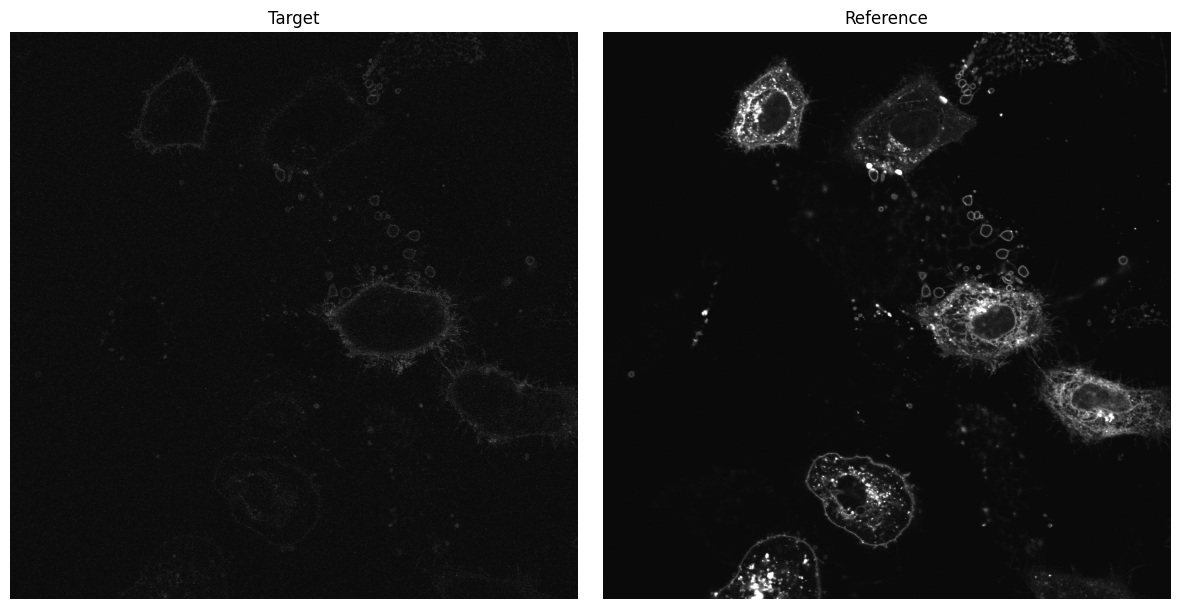

In [11]:
# 画像を読み込み
target_img = Image.open(test_target)
reference_img = Image.open(test_reference)

# RGBに変換（グレースケールの場合）
if target_img.mode != 'RGB':
    target_img = target_img.convert('RGB')
if reference_img.mode != 'RGB':
    reference_img = reference_img.convert('RGB')

print(f"Target画像サイズ: {target_img.size}")
print(f"Reference画像サイズ: {reference_img.size}")

# 画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(target_img)
axes[0].set_title('Target')
axes[0].axis('off')
axes[1].imshow(reference_img)
axes[1].set_title('Reference')
axes[1].axis('off')
plt.tight_layout()
plt.show()

### Step 2: Cellpose-SAM セグメンテーション

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


prev_labels TIFFによるID維持を適用しました（4件マッピング）
検出された細胞数: 4


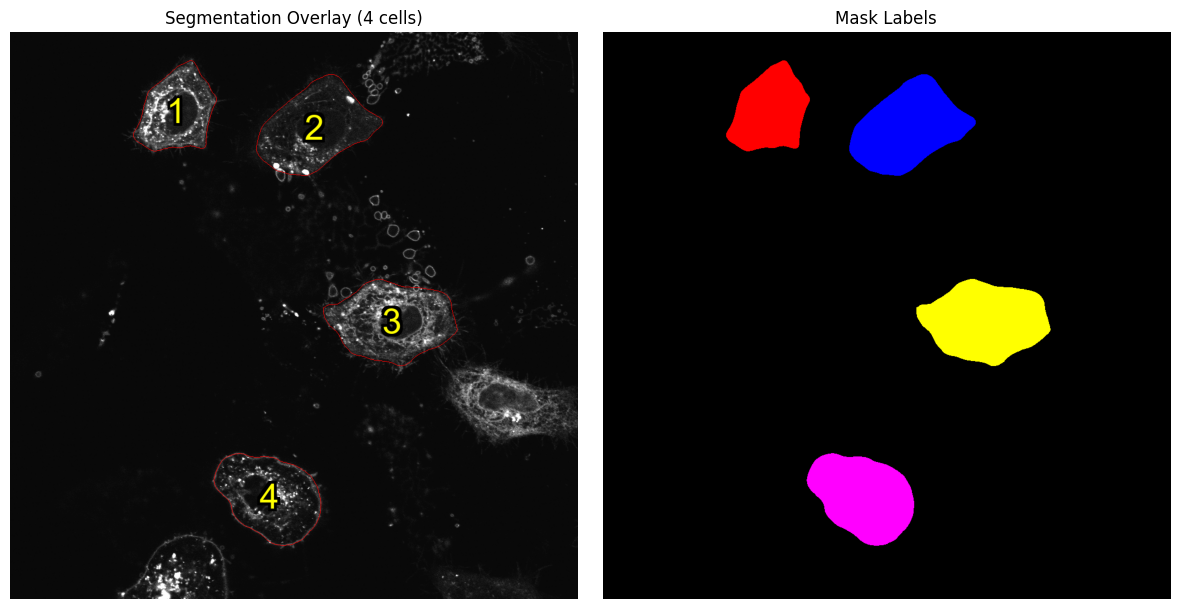

In [12]:
# セグメンテーション実行 (edge除外パラメータを追加)
seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
    target_img,
    reference_img,
    seg_source=SEG_PARAMS['source'],
    seg_channel=SEG_PARAMS['channel'],
    diameter=SEG_PARAMS['diameter'],
    flow_threshold=SEG_PARAMS['flow_threshold'],
    cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
    use_gpu=SEG_PARAMS['use_gpu'],
    drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
    inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
    edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
)

# オプション: 任意のprev_labels TIFFからID維持を適用
if TRACKING_PARAMS['enable']:
    prev_labels = None
    if TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
        try:
            prev_labels = load_label_tiff(TRACKING_INPUT['tiff_path'])
        except Exception as e:
            print(f"[WARN] prev_labels TIFFの読み込みに失敗: {e}")
        
        if prev_labels is not None:
            # UI版と同じ前処理: ndim, dtype, shape確認
            if prev_labels.ndim != 2:
                prev_labels = np.squeeze(prev_labels)
            prev_labels = prev_labels.astype(np.int32, copy=False)
            curr_masks = masks.astype(np.int32, copy=False)
            
            if prev_labels.shape != curr_masks.shape:
                print(f"[WARN] prev_labels TIFFのサイズが不一致のため無視: {prev_labels.shape} != {curr_masks.shape}")
                prev_labels = None
    # prev_labels が与えられた場合のみ単発テストで適用（autoはバッチで適用）
    if prev_labels is not None:
        relabeled, mapping_df, _ = relabel_to_previous(prev_labels, curr_masks, iou_threshold=TRACKING_PARAMS['iou_threshold'])
        masks = relabeled
        print(f"prev_labels TIFFによるID維持を適用しました（{len(mapping_df)}件マッピング）")

n_cells = len(np.unique(masks)) - 1  # 背景を除く
print(f"検出された細胞数: {n_cells}")

# セグメンテーション結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(seg_overlay)
axes[0].set_title(f'Segmentation Overlay ({n_cells} cells)')
axes[0].axis('off')
axes[1].imshow(mask_img)
axes[1].set_title('Mask Labels')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 3: Target/Reference マスク適用

マスク適用完了


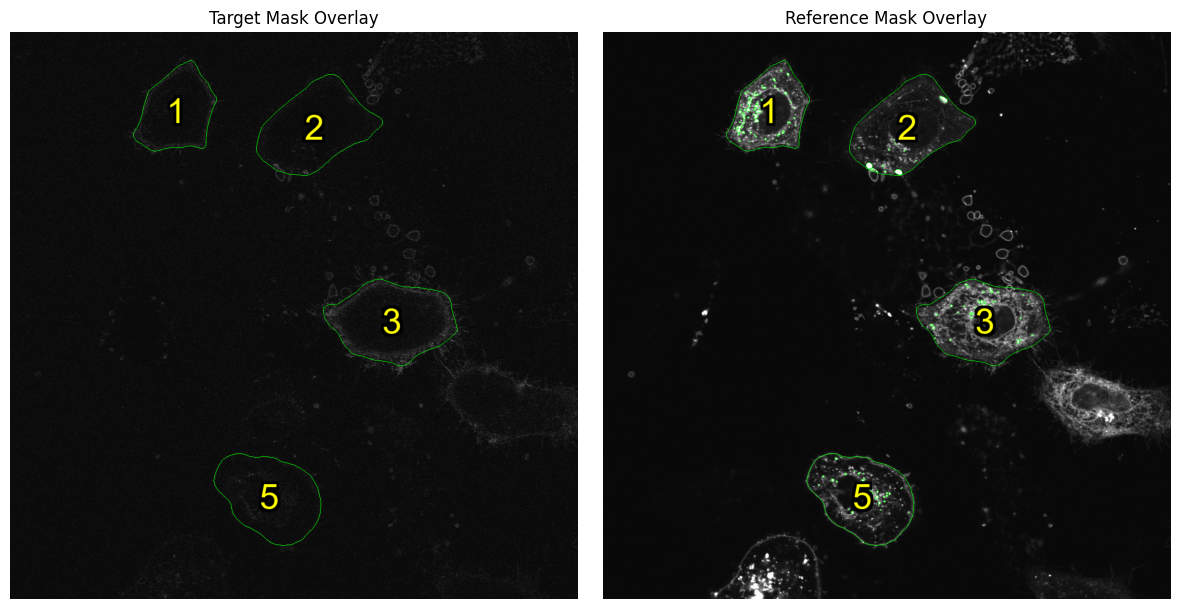

In [13]:
# Targetマスク適用
tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
    target_img,
    masks,
    measure_channel=TARGET_MASK_PARAMS['channel'],
    sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
    mask_mode=TARGET_MASK_PARAMS['mode'],
    pct=TARGET_MASK_PARAMS['percentile'],
    min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
    mask_name="target_mask",
)

# Referenceマスク適用
ref_overlay, ref_tiff, ref_mask = apply_mask(
    reference_img,
    masks,
    measure_channel=REFERENCE_MASK_PARAMS['channel'],
    sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
    mask_mode=REFERENCE_MASK_PARAMS['mode'],
    pct=REFERENCE_MASK_PARAMS['percentile'],
    min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
    mask_name="reference_mask",
)

print("マスク適用完了")

# マスク結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_overlay)
axes[0].set_title('Target Mask Overlay')
axes[0].axis('off')
axes[1].imshow(ref_overlay)
axes[1].set_title('Reference Mask Overlay')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 4: 定量化 (Integrate & Quantify)

In [14]:
# 定量化実行
result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,
    ref_mask,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

(
    tgt_and_overlay, ref_and_overlay, and_mask_tiff,
    quant_df, quant_csv,
    tgt_on_and, ref_on_and, ratio_on_and
) = result

print(f"定量化完了: {len(quant_df)} 細胞")
print("\n定量化結果（最初の5行）:")
display(quant_df.head())


定量化完了: 4 細胞

定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,16515,707.651235,16059,688.112091,110351.382812,6.871622,9.304551,9.939775e+05,61.895355,...,2621.331863,0.163231,0.298706,0.111020,114006.968750,6.903238,9.280925,1.105694e+06,66.950920,54.132923
1,2,24723,1059.355827,24463,1048.215087,100601.484375,4.112393,6.094122,6.381943e+05,26.088146,...,6423.493518,0.262580,4.133089,0.157635,109590.296875,4.432726,7.177006,7.018926e+05,28.390266,34.730644
2,3,25871,1108.546479,25580,1096.077420,304158.312500,11.890473,14.052004,1.490546e+06,58.269978,...,8483.399367,0.331642,2.531569,0.204058,307891.312500,11.901021,14.061305,1.561839e+06,60.370258,46.375629
3,5,22592,968.044608,22432,961.188768,115289.453125,5.139508,6.615266,7.058742e+05,31.467291,...,12389.753488,0.552325,9.247098,0.163329,117690.726562,5.209398,6.738604,7.450731e+05,32.979511,39.561024


### Step 5: Radial Mask定量化

細胞の外周部分（radial ring）のみでの定量化を行います。

Radial Mask生成完了
  内側境界: 90.0%
  外側境界: 100.0%

Radial Mask定量化完了: 4 細胞

Radial Mask定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,16515,707.651235,2806,120.234294,43647.261719,15.554976,12.743279,119377.203125,42.543552,...,1311.459522,0.467377,0.524077,0.365625,114006.968750,6.903238,9.280925,1.105694e+06,66.950920,54.132923
1,2,24723,1059.355827,3669,157.212981,27536.720703,7.505239,8.209787,101441.414062,27.648247,...,2257.903418,0.615400,10.566792,0.271454,109590.296875,4.432726,7.177006,7.018926e+05,28.390266,34.730644
2,3,25871,1108.546479,4205,180.180045,91676.187500,21.801710,17.038668,148440.296875,35.300903,...,3873.230591,0.921101,6.170578,0.617596,307891.312500,11.901021,14.061305,1.561839e+06,60.370258,46.375629
3,5,22592,968.044608,3549,152.071101,21472.582031,6.050319,6.842875,134653.937500,37.941376,...,877.439694,0.247236,0.527695,0.159465,117690.726562,5.209398,6.738604,7.450731e+05,32.979511,39.561024


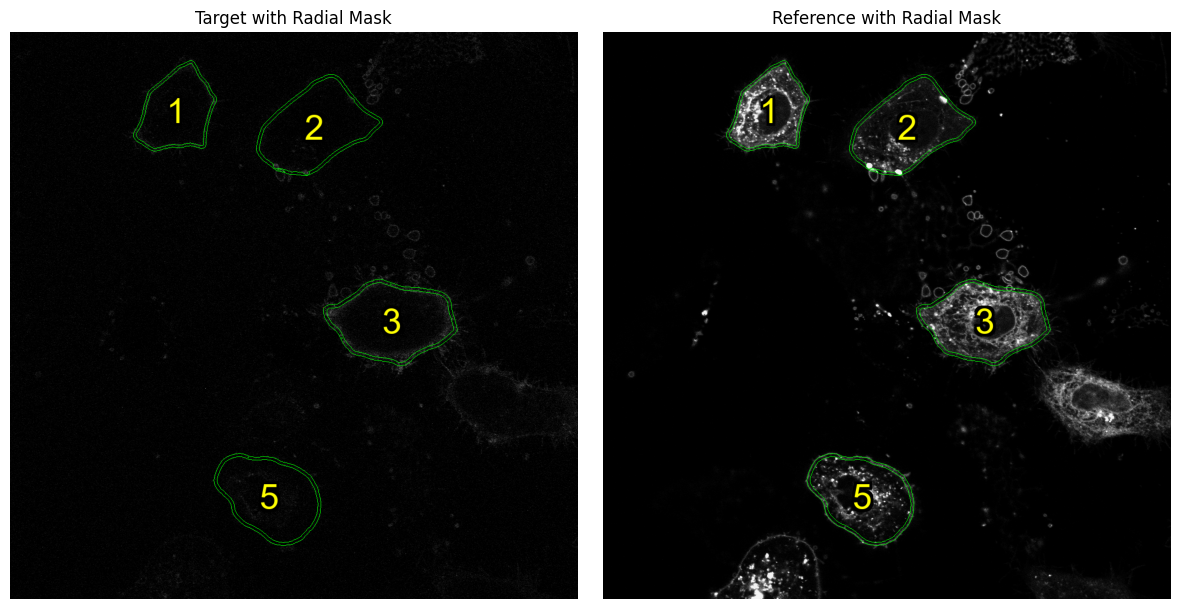

In [15]:

# 1. Radial Maskを生成
radial_overlay, radial_bool_mask, radial_label_mask, radial_bool_tiff, radial_label_tiff = radial_mask(
    masks=masks,
    inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
    outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
    min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
)

print(f"Radial Mask生成完了")
print(f"  内側境界: {RADIAL_MASK_PARAMS['inner_pct']}%")
print(f"  外側境界: {RADIAL_MASK_PARAMS['outer_pct']}%")

# # Radial Maskを表示
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(radial_overlay)
# axes[0].set_title('Radial Mask Overlay')
# axes[0].axis('off')
# axes[1].imshow(radial_bool_mask, cmap='gray')
# axes[1].set_title('Radial Mask (Boolean)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

# 2. Radial Maskを使った定量化
# Target/Reference maskの代わりにradial maskを使い、roi_mask/roi_labelsも指定
radial_quant_result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,  # Target mask（通常のマスク）
    ref_mask,  # Reference mask（通常のマスク）
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
    roi_mask=radial_bool_mask,  # Radial MaskをROIとして指定
    roi_labels=radial_label_mask,  # Radial LabelをROIラベルとして指定
)

(
    radial_tgt_and_overlay, radial_ref_and_overlay, radial_and_mask_tiff,
    radial_quant_df, radial_quant_csv,
    radial_tgt_on_and, radial_ref_on_and, radial_ratio_on_and
) = radial_quant_result

print(f"\nRadial Mask定量化完了: {len(radial_quant_df)} 細胞")
print("\nRadial Mask定量化結果（最初の5行）:")
display(radial_quant_df.head())

# Radial Maskを適用したオーバーレイ画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(radial_tgt_and_overlay)
axes[0].set_title('Target with Radial Mask')
axes[0].axis('off')
axes[1].imshow(radial_ref_and_overlay)
axes[1].set_title('Reference with Radial Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 6: Radial Profile 解析


In [16]:
# Radial Profile解析実行
radial_df, radial_csv = radial_profile_all_cells(
    target_img,
    reference_img,
    masks,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    start_pct=RADIAL_PARAMS['start_pct'],
    end_pct=RADIAL_PARAMS['end_pct'],
    window_size_pct=RADIAL_PARAMS['window_size_pct'],
    window_step_pct=RADIAL_PARAMS['window_step_pct'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

print(f"Radial Profile解析完了: {len(radial_df)} データポイント")
print("\nRadial Profile結果（最初の5行）:")
display(radial_df.head())

Radial Profile解析完了: 584 データポイント

Radial Profile結果（最初の5行）:


,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
0,1,0.0,5.0,2.5,92,1.771554,18.570359,3.025824,5.328971,0.315464,0.555584,0.099628,0.176883,0.018441,92
1,1,1.0,6.0,3.5,104,2.214056,18.708305,4.226346,5.211633,0.414427,0.511043,0.121780,0.226952,0.022254,104
2,1,2.0,7.0,4.5,130,2.136803,18.885210,3.922761,5.907476,0.344049,0.518120,0.120065,0.213238,0.018702,130
3,1,3.0,8.0,5.5,149,2.095291,18.465686,3.962584,6.104811,0.324628,0.500126,0.114086,0.200975,0.016465,149
4,1,4.0,9.0,6.5,171,1.921977,18.226571,3.767570,6.335269,0.288113,0.484470,0.108966,0.197474,0.015101,171


### Step 7: Peak Difference 解析

In [17]:
# Peak Difference解析実行 (SG + first_local_top対応)
peak_df = compute_radial_peak_difference(
    radial_df,
    quant_df=quant_df,
    algo=PEAK_PARAMS['algo'],
    min_pct=PEAK_PARAMS['min_pct'],
    max_pct=PEAK_PARAMS['max_pct'],
    sg_window=PEAK_PARAMS['sg_window'],
    sg_poly=PEAK_PARAMS['sg_poly'],
    peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
)

print(f"Peak Difference解析完了: {len(peak_df)} 細胞")
print("\nPeak Difference結果:")
display(peak_df)

# 統計情報
if not peak_df.empty and 'difference_pct' in peak_df.columns:
    print(f"\nPeak Difference統計:")
    print(f"  平均: {peak_df['difference_pct'].mean():.2f} %")
    print(f"  中央値: {peak_df['difference_pct'].median():.2f} %")
    print(f"  標準偏差: {peak_df['difference_pct'].std():.2f} %")


Peak Difference解析完了: 4 細胞

Peak Difference結果:


,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,1,92.5,84.5,8.0,67.066568,61.266217,5.800352,13.882780,12.682107,1.200673,18.084020,75.062530,0.240919,0.795199,0.020607,15,True
1,2,91.5,88.5,3.0,81.170224,78.508905,2.661319,16.802236,16.251343,0.550893,9.579696,47.953948,0.199769,0.657252,0.015536,11,True
2,3,89.5,83.5,6.0,81.218452,75.773639,5.444812,16.812220,15.685143,1.127076,26.690262,77.797078,0.343075,0.717246,0.034254,16,True
3,5,64.5,98.5,-34.0,54.696825,83.529260,-28.832435,11.322243,17.290557,-5.968314,5.266421,51.111768,0.103037,0.705896,0.033566,1,False



Peak Difference統計:
  平均: -4.25 %
  中央値: 4.50 %
  標準偏差: 19.94 %


### Step 7-1: Radial Profile グラフの生成（全ラベル）


4 個の細胞についてRadial Profileグラフを生成中...


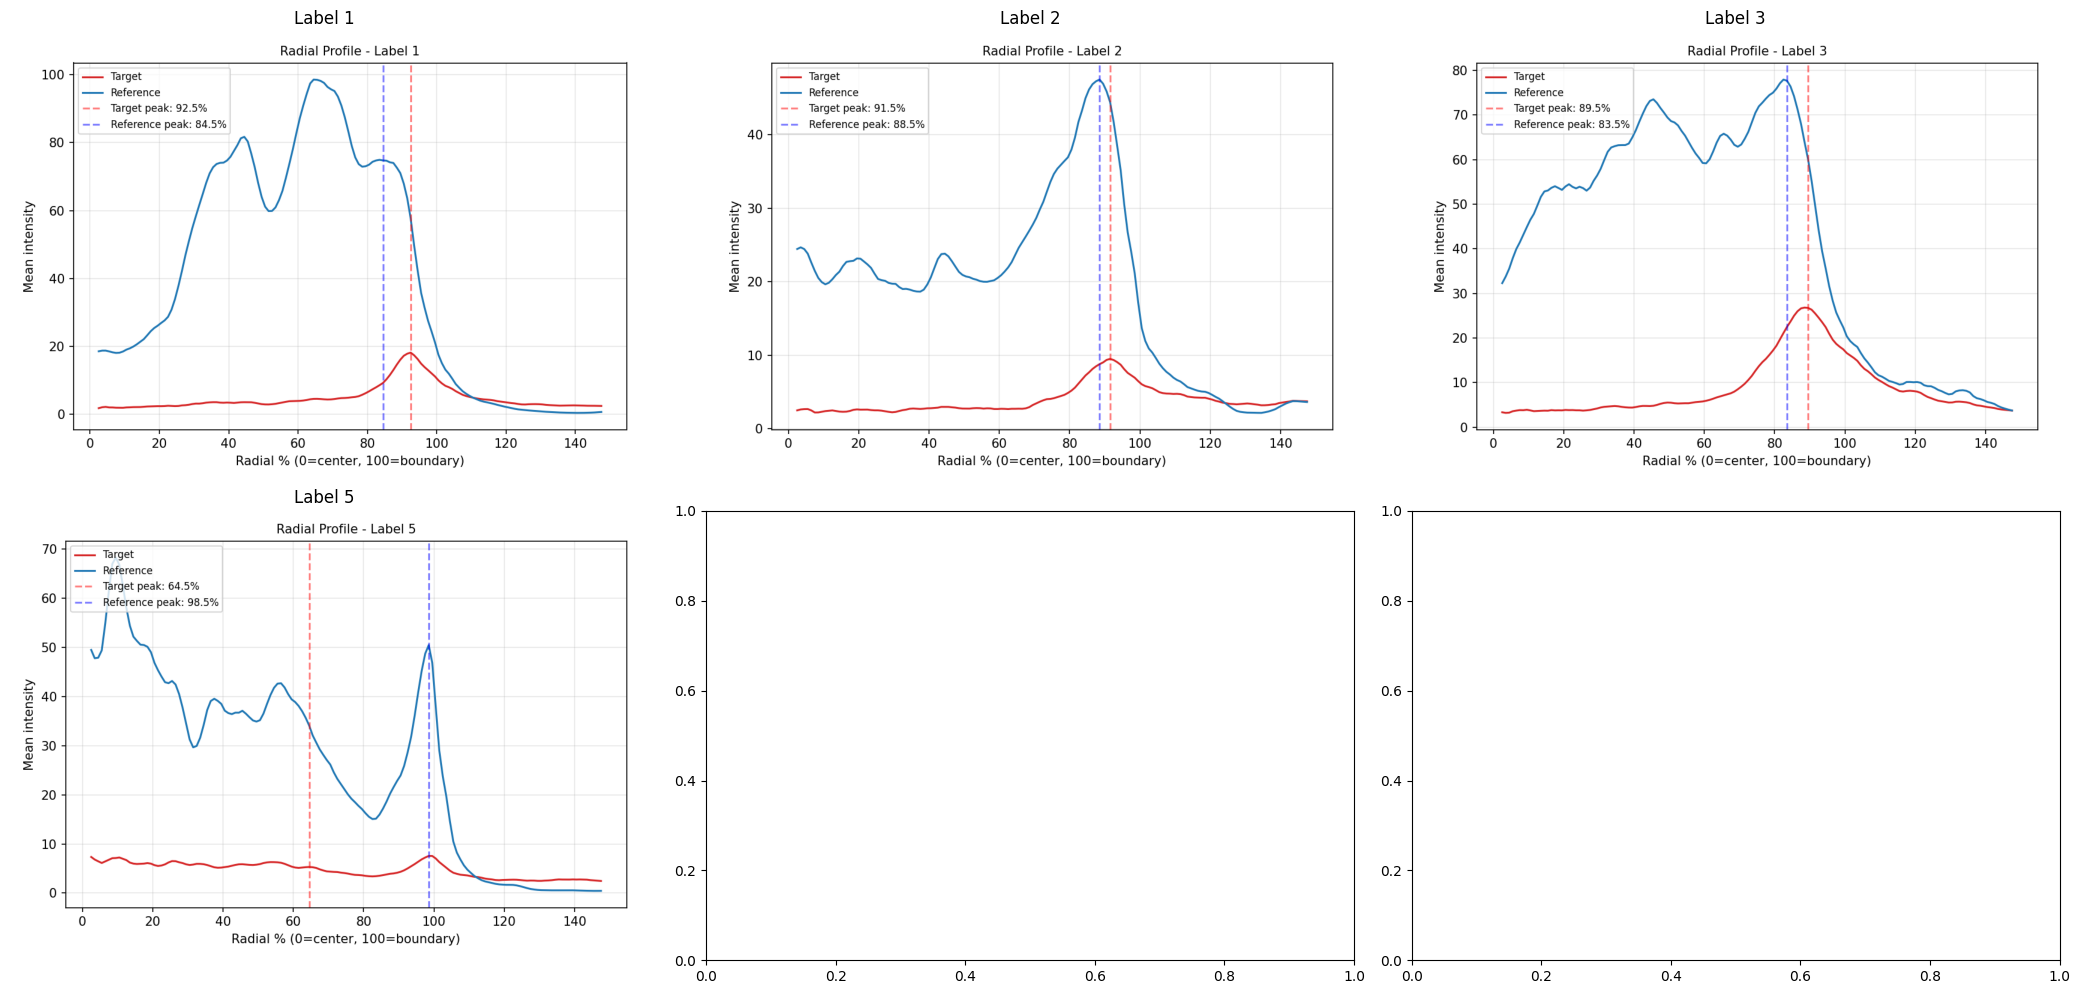

In [18]:
# すべてのラベルについてRadial Profileグラフを生成（T/Rは表示しない）
if not radial_df.empty and not peak_df.empty:
    # ユニークなラベルを取得
    unique_labels = sorted(radial_df['label'].unique())
    
    print(f"\n{len(unique_labels)} 個の細胞についてRadial Profileグラフを生成中...")
    
    
    # グラフを3列ずつすべて表示
    
    if unique_labels:
        n_column = 3
        n_row = (len(unique_labels) + n_column - 1) // n_column
        
        fig, axes = plt.subplots(n_row, n_column, figsize=(7 * n_column, 5 * n_row))
        axes = axes.flatten()  # 2D配列を1Dに変換

        for i, label in enumerate(unique_labels):
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            axes[i].imshow(plot_img)
            axes[i].axis('off')
            axes[i].set_title(f'Label {label}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
else:
    print("Radial ProfileまたはPeak Differenceデータがありません")

### 結果の保存（テスト用）

In [19]:

os.makedirs(sample_output_dir, exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)

# CSVファイルを保存
quant_output = os.path.join(sample_output_dir, "quantification.csv")
quant_df.to_csv(quant_output, index=False)
print(f"定量化結果を保存: {quant_output}")

radial_output = os.path.join(sample_output_dir, "radial_profiles.csv")
radial_df.to_csv(radial_output, index=False)
print(f"Radial Profile結果を保存: {radial_output}")

peak_output = os.path.join(sample_output_dir, "peak_differences.csv")
peak_df.to_csv(peak_output, index=False)
print(f"Peak Difference結果を保存: {peak_output}")

# Radial Mask定量化結果を保存（有効な場合）
if radial_quant_df is not None:
    radial_quant_output = os.path.join(sample_output_dir, "radial_mask_quantification.csv")
    radial_quant_df.to_csv(radial_quant_output, index=False)
    print(f"Radial Mask定量化結果を保存: {radial_quant_output}")

# オーバーレイ画像を保存
seg_overlay.save(os.path.join(sample_output_dir, "overlays", "segmentation_overlay.png"))
tgt_overlay.save(os.path.join(sample_output_dir, "overlays", "target_mask_overlay.png"))
ref_overlay.save(os.path.join(sample_output_dir, "overlays", "reference_mask_overlay.png"))

# Radial Maskオーバーレイを保存（有効な場合）
if radial_overlay is not None:
    radial_overlay.save(os.path.join(sample_output_dir, "overlays", "radial_mask_overlay.png"))

# マスクTIFFを保存
Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", "cell_masks.tif"))

# Radial Maskを保存（有効な場合）
if radial_bool_mask is not None:
    Image.fromarray((radial_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", "radial_mask.tif"))

# Radial Profileグラフを保存
if not radial_df.empty and not peak_df.empty:
    for label in unique_labels:
        plot_img = plot_radial_profile_with_peaks(
            df=radial_df,
            peak_df=peak_df,
            label_filter=label,
            window_bins=1,
            show_errorbars=False,
            show_ratio=False,
        )
        plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"radial_profile_label_{label}.png")
        plot_img.save(plot_path)
        print(f"Radial Profileグラフを保存: {plot_path}")

print(f"\nすべての結果を保存: {sample_output_dir}")

定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\quantification.csv
Radial Profile結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\radial_profiles.csv
Peak Difference結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\peak_differences.csv
Radial Mask定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\radial_mask_quantification.csv
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\radial_profile_plots\radial_profile_label_1.png
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\radial_profile_plots\radial_profile_label_2.png
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002\radial_profile_plots\radial_profile_label_3.png
Ra

## 6. バッチ処理（全画像ペア）

上記のテストが成功したら、全画像ペアをバッチ処理します

In [20]:
# バッチ処理関数 (ID維持 + SG + first_local_top peak解析 対応)
def process_image_pair(target_path, reference_path, output_dir, target_pattern, prev_labels=None):
    """
    1ペアの画像を処理する関数
    prev_labels: 直前フレームのラベル (ID維持用) / None
    戻り値: dict with keys including 'masks' (relabel後)
    """
    try:
        # base_nameを生成
        base_name = generate_base_name(target_path, target_pattern)
        
        # サンプル用の出力ディレクトリを作成
        sample_output_dir = os.path.join(output_dir, base_name)
        os.makedirs(sample_output_dir, exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)
        
        # 変数の初期化
        rad_overlay = None
        rad_bool_mask = None
        rad_label_mask = None
        radial_tar_overlay = None
        radial_ref_overlay = None
        radial_quant_df = None
        
        # 1. 画像読み込み
        target_img = Image.open(target_path)
        reference_img = Image.open(reference_path)
        if target_img.mode != 'RGB':
            target_img = target_img.convert('RGB')
        if reference_img.mode != 'RGB':
            reference_img = reference_img.convert('RGB')
        
        # 2. セグメンテーション (edge除外オプション適用)
        seg_overlay, seg_tiff, mask_img, masks_raw = run_segmentation(
            target_img,
            reference_img,
            seg_source=SEG_PARAMS['source'],
            seg_channel=SEG_PARAMS['channel'],
            diameter=SEG_PARAMS['diameter'],
            flow_threshold=SEG_PARAMS['flow_threshold'],
            cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
            use_gpu=SEG_PARAMS['use_gpu'],
            drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
            inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
            edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
        )
        masks = masks_raw.copy()
        n_cells = len(np.unique(masks)) - 1

        # 2.1 ID維持 (前フレームがあり有効ならIoUマッチ)
        if TRACKING_PARAMS['enable'] and prev_labels is not None:
            # UI版と同じ前処理
            prev_arr = prev_labels.astype(np.int32, copy=False)
            curr = masks.astype(np.int32, copy=False)
            
            if prev_arr.shape == curr.shape:
                relabeled, mapping_df, _ = relabel_to_previous(prev_arr, curr, iou_threshold=TRACKING_PARAMS['iou_threshold'])
                masks = relabeled  # 上書き
                # マッピング情報保存
                mapping_csv = os.path.join(sample_output_dir, f"{base_name}_id_mapping.csv")
                mapping_df.to_csv(mapping_csv, index=False)
        
        # 3. マスク適用
        tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
            target_img, masks,
            measure_channel=TARGET_MASK_PARAMS['channel'],
            sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
            mask_mode=TARGET_MASK_PARAMS['mode'],
            pct=TARGET_MASK_PARAMS['percentile'],
            min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
            mask_name="target_mask",
        )
        ref_overlay, ref_tiff, ref_mask = apply_mask(
            reference_img, masks,
            measure_channel=REFERENCE_MASK_PARAMS['channel'],
            sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
            mask_mode=REFERENCE_MASK_PARAMS['mode'],
            pct=REFERENCE_MASK_PARAMS['percentile'],
            min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
            mask_name="reference_mask",
        )
        
        # 4. 定量化
        result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        quant_df = result[3]
        
        # 5. Radial Mask定量化
        rad_overlay, rad_bool_mask, rad_label_mask, rad_bool_tiff, rad_label_tiff = radial_mask(
            masks=masks,
            inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
            outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
            min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
        )
        radial_quant_result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
            roi_mask=rad_bool_mask,
            roi_labels=rad_label_mask,
        )
        radial_tar_overlay = radial_quant_result[0]
        radial_ref_overlay = radial_quant_result[1]
        radial_quant_df = radial_quant_result[3]
        
        # 6. Radial Profile (RAW) 解析
        radial_df_raw, radial_csv_raw = radial_profile_all_cells(
            target_img, reference_img, masks,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            start_pct=RADIAL_PARAMS['start_pct'],
            end_pct=RADIAL_PARAMS['end_pct'],
            window_size_pct=RADIAL_PARAMS['window_size_pct'],
            window_step_pct=RADIAL_PARAMS['window_step_pct'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        
        # 7. Peak Difference (SG平滑 + first_local_top 指定可)
        peak_df = compute_radial_peak_difference(
            radial_df_raw,
            quant_df=quant_df,
            min_pct=PEAK_PARAMS['min_pct'],
            max_pct=PEAK_PARAMS['max_pct'],
            algo=PEAK_PARAMS['algo'],
            sg_window=PEAK_PARAMS['sg_window'],
            sg_poly=PEAK_PARAMS['sg_poly'],
            peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
        )
        peak_csv = os.path.join(sample_output_dir, f"{base_name}_peak_differences.csv")
        peak_df.to_csv(peak_csv, index=False)

        # 結果保存（CSVファイル）- base_nameをファイル名の頭に付ける
        quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_quantification.csv"), index=False)
        radial_df_raw.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_profiles_raw.csv"), index=False)
        if radial_quant_df is not None:
            radial_quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_mask_quantification.csv"), index=False)
        
        # オーバーレイ画像を保存 - base_nameをファイル名の頭に付ける
        seg_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_segmentation_overlay.png"))
        tgt_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_mask_overlay.png"))
        ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_mask_overlay.png"))
        if rad_overlay is not None:
            rad_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_radial_mask_overlay.png"))
        if radial_tar_overlay is not None:
            radial_tar_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_radial_overlay.png"))
        if radial_ref_overlay is not None:
            radial_ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_radial_overlay.png"))

        # マスクTIFFを保存
        Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_cell_masks.tif"))
        if tgt_mask is not None and tgt_mask.any():
            Image.fromarray((tgt_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_target_mask.tif"))
        if ref_mask is not None and ref_mask.any():
            Image.fromarray((ref_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_reference_mask.tif"))
        if rad_bool_mask is not None:
            Image.fromarray((rad_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_radial_mask.tif"))

        # Radial Profileプロット生成（ピーク差分ラインは後で追加可能）
        unique_labels = sorted(radial_df_raw['label'].unique()) if not radial_df_raw.empty else []
        for label in unique_labels:
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df_raw,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"{base_name}_label{label}_radial_profile.png")
            plot_img.save(plot_path)

        return {
            'base_name': base_name,
            'n_cells': n_cells,
            'status': 'success',
            'quant_df': quant_df,
            'radial_df': radial_df_raw,
            'peak_df': peak_df,
            'radial_quant_df': radial_quant_df,
            'sample_dir': sample_output_dir,
            'masks': masks,  # relabel後のマスク
        }
        
    except Exception as e:
        import traceback
        return {
            'base_name': Path(target_path).stem,
            'status': 'error',
            'error': str(e),
            'traceback': traceback.format_exc(),
        }

print("バッチ処理関数を更新しました (ID維持 + SG + First Local Top 対応)")


バッチ処理関数を更新しました (ID維持 + SG + First Local Top 対応)


In [21]:
# バッチ処理実行（同一サンプルのフレーム間でID維持）
results = []
errors = []

print(f"\n{len(IMAGE_PAIRS)} ペアの画像を処理開始...\n")

import re

def parse_base_and_z_from_target_path(target_path, target_pattern):
    fn = os.path.basename(target_path)
    m = re.match(target_pattern, fn)
    if m:
        base = m.group(1)
        znum = m.group(2) if len(m.groups()) > 1 else ""
        return base, znum
    return Path(target_path).stem, ""

# グループ化: base毎にZ順に並べる
from collections import defaultdict
by_base = defaultdict(list)
for tgt, ref in IMAGE_PAIRS:
    base, z = parse_base_and_z_from_target_path(tgt, TARGET_PATTERN)
    by_base[base].append((z, tgt, ref))

# 先頭フレームのprev_labelsを外部TIFFからシード（任意）
prev_labels_seed = None
if TRACKING_PARAMS['enable'] and TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
    prev_labels_seed = load_label_tiff(TRACKING_INPUT['tiff_path'])
    if prev_labels_seed is None:
        print("[INFO] prev_labels TIFFは使用されません（未指定または読み込み失敗）。")

# Z昇順（Z001, Z002, ... の辞書順でOK）
for base, items in by_base.items():
    items_sorted = sorted(items, key=lambda x: x[0])
    prev_labels = prev_labels_seed  # ベース毎の先頭にシードを適用
    print(f"\n== サンプル: {base} / フレーム数: {len(items_sorted)} ==")
    for i, (z, target_path, reference_path) in enumerate(items_sorted, 1):
        print(f"  [{i}/{len(items_sorted)}] 処理中: {Path(target_path).name}")
        # 形状不一致ならシードを捨てる（初回のみ）+ UI版と同じ前処理
        if prev_labels is not None:
            try:
                tmp_img = Image.open(target_path)
                if tmp_img.mode != 'RGB':
                    tmp_img = tmp_img.convert('RGB')
                H, W = tmp_img.size[1], tmp_img.size[0]
                
                # UI版と同じnp.squeeze処理
                if prev_labels.ndim != 2:
                    prev_labels = np.squeeze(prev_labels)
                prev_labels = prev_labels.astype(np.int32, copy=False)
                
                if prev_labels.shape != (H, W):
                    print(f"    [WARN] prev_labelsシードのサイズ不一致のため無視: {prev_labels.shape} != {(H,W)}")
                    prev_labels = None
            except Exception:
                prev_labels = None
        result = process_image_pair(
            target_path, reference_path, OUTPUT_DIR, TARGET_PATTERN,
            prev_labels=prev_labels if TRACKING_PARAMS['enable'] else None
        )
        if result['status'] == 'success':
            print(f"    ✓ 成功: {result['n_cells']} 細胞検出 → {result['sample_dir']}")
            results.append(result)
            prev_labels = result.get('masks', None)  # 次フレームへ
        else:
            print(f"    ✗ エラー: {result['error']}")
            errors.append(result)

print(f"\n\n処理完了: {len(results)} 成功, {len(errors)} エラー")



32 ペアの画像を処理開始...


== サンプル: 4h.0 / フレーム数: 4 ==
  [1/4] 処理中: 4h.0_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0_Z001
  [2/4] 処理中: 4h.0_C001Z002.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0_Z002
  [3/4] 処理中: 4h.0_C001Z003.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0_Z003
  [4/4] 処理中: 4h.0_C001Z004.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0_Z004

== サンプル: 4h.0.5 / フレーム数: 4 ==
  [1/4] 処理中: 4h.0.5_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0.5_Z001
  [2/4] 処理中: 4h.0.5_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0.5_Z002
  [3/4] 処理中: 4h.0.5_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0.5_Z003
  [4/4] 処理中: 4h.0.5_C001Z004.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.0.5_Z004

== サンプル: 4h.1.0 / フレーム数: 4 ==
  [1/4] 処理中: 4h.1.0_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.1.0_Z001
  [2/4] 処理中: 4h.1.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.1.0_Z002
  [3/4] 処理中: 4h.1.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 7 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.1.0_Z003
  [4/4] 処理中: 4h.1.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.1.0_Z004

== サンプル: 4h.10 / フレーム数: 4 ==
  [1/4] 処理中: 4h.10_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.10_Z001
  [2/4] 処理中: 4h.10_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.10_Z002
  [3/4] 処理中: 4h.10_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.10_Z003
  [4/4] 処理中: 4h.10_C001Z004.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.10_Z004

== サンプル: 4h.2.0 / フレーム数: 4 ==
  [1/4] 処理中: 4h.2.0_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.2.0_Z001
  [2/4] 処理中: 4h.2.0_C001Z002.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.2.0_Z002
  [3/4] 処理中: 4h.2.0_C001Z003.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.2.0_Z003
  [4/4] 処理中: 4h.2.0_C001Z004.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 6 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.2.0_Z004

== サンプル: 4h.20 / フレーム数: 4 ==
  [1/4] 処理中: 4h.20_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z001
  [2/4] 処理中: 4h.20_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z002
  [3/4] 処理中: 4h.20_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z003
  [4/4] 処理中: 4h.20_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.20_Z004

== サンプル: 4h.30 / フレーム数: 4 ==
  [1/4] 処理中: 4h.30_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.30_Z001
  [2/4] 処理中: 4h.30_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.30_Z002
  [3/4] 処理中: 4h.30_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.30_Z003
  [4/4] 処理中: 4h.30_C001Z004.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 4 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.30_Z004

== サンプル: 4h.5.0 / フレーム数: 4 ==
  [1/4] 処理中: 4h.5.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.5.0_Z001
  [2/4] 処理中: 4h.5.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.5.0_Z002
  [3/4] 処理中: 4h.5.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.5.0_Z003
  [4/4] 処理中: 4h.5.0_C001Z004.tif


Resizing is deprecated in v4.0.1+


    ✓ 成功: 5 細胞検出 → E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\4h.5.0_Z004


処理完了: 32 成功, 0 エラー


## 7. 全体サマリーの作成

In [22]:
# 全サンプルの定量化結果を統合
all_quant_dfs = []
for res in results:
    df = res['quant_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_quant_dfs.append(df)

if all_quant_dfs:
    combined_quant = pd.concat(all_quant_dfs, ignore_index=True)
    
    # sample_nameから additive と Z を抽出
    # パターン: "4h.[additive]_Z[Z]" → additive:float, Z:int
    def parse_sample_name(name):
        import re
        # 例: "4h.0_Z001" → additive=0.0, Z=1
        # 例: "4h.0.5_Z002" → additive=0.5, Z=2
        # 例: "4h.1.0_Z003" → additive=1.0, Z=3
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_quant['additive'], combined_quant['Z'] = zip(*combined_quant['sample_name'].apply(parse_sample_name))
    
    # 列の順番を調整: sample_name, additive, Z, その他の列
    cols = combined_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # sample_nameの次
    cols.insert(2, 'Z')         # additiveの次
    combined_quant = combined_quant[cols]
    
    combined_quant_path = os.path.join(OUTPUT_DIR, "all_samples_quantification.csv")
    combined_quant.to_csv(combined_quant_path, index=False)
    print(f"全サンプルの定量化結果を保存: {combined_quant_path}")
    print(f"  総サンプル数: {len(results)}")
    print(f"  総細胞数: {len(combined_quant)}")
    display(combined_quant.head(10))

# 全サンプルのRadial Mask定量化結果を統合
all_radial_quant_dfs = []
for res in results:
    radial_df = res.get('radial_quant_df', None)
    if radial_df is not None:
        df = radial_df.copy()
        df.insert(0, 'sample_name', res['base_name'])
        all_radial_quant_dfs.append(df)
if all_radial_quant_dfs:
    combined_radial_quant = pd.concat(all_radial_quant_dfs, ignore_index=True)
    
    # sample_nameから additive と Z を抽出
    def parse_sample_name(name):
        import re
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_radial_quant['additive'], combined_radial_quant['Z'] = zip(*combined_radial_quant['sample_name'].apply(parse_sample_name))
    
    # 列の順番を調整: sample_name, additive, Z, その他の列
    cols = combined_radial_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # sample_nameの次
    cols.insert(2, 'Z')         # additiveの次
    combined_radial_quant = combined_radial_quant[cols]
    
    combined_radial_quant_path = os.path.join(OUTPUT_DIR, "all_samples_radial_mask_quantification.csv")
    combined_radial_quant.to_csv(combined_radial_quant_path, index=False)
    print(f"\n全サンプルのRadial Mask定量化結果を保存: {combined_radial_quant_path}")
    print(f"  総サンプル数: {len(all_radial_quant_dfs)}")
    print(f"  総細胞数: {len(combined_radial_quant)}")
    display(combined_radial_quant.head(10))

# 全サンプルのPeak Difference結果を統合
all_peak_dfs = []
for res in results:
    df = res['peak_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_peak_dfs.append(df)

if all_peak_dfs:
    combined_peak = pd.concat(all_peak_dfs, ignore_index=True)
    
    # sample_nameから additive と Z を抽出
    def parse_sample_name(name):
        import re
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_peak['additive'], combined_peak['Z'] = zip(*combined_peak['sample_name'].apply(parse_sample_name))
    
    # 列の順番を調整: sample_name, additive, Z, その他の列
    cols = combined_peak.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # sample_nameの次
    cols.insert(2, 'Z')         # additiveの次
    combined_peak = combined_peak[cols]
    
    combined_peak_path = os.path.join(OUTPUT_DIR, "all_samples_peak_differences.csv")
    combined_peak.to_csv(combined_peak_path, index=False)
    print(f"\n全サンプルのPeak Difference結果を保存: {combined_peak_path}")
    display(combined_peak.head(10))
    

# エラーサマリー
if errors:
    print(f"\n\n=== エラー詳細 ===")
    for err in errors:
        print(f"\n{err['base_name']}:")
        print(f"  エラー: {err['error']}")
        if 'traceback' in err:
            print(f"  トレースバック:")
            for line in err['traceback'].split('\n')[:5]:  # 最初の5行のみ表示
                print(f"    {line}")

全サンプルの定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\all_samples_quantification.csv
  総サンプル数: 32
  総細胞数: 167


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,4h.0_Z001,0.0,1,1,15436,661.417164,14778,633.222522,42168.257812,2.853448,...,1118.007218,0.075653,0.164736,0.046532,46341.195312,3.002151,4.628110,1.067411e+06,69.150749,59.074409
1,4h.0_Z001,0.0,1,2,21116,904.799484,20709,887.359941,57649.917969,2.783810,...,3525.901660,0.170259,0.377734,0.096887,59884.535156,2.835979,4.510133,6.947274e+05,32.900524,42.175560
2,4h.0_Z001,0.0,1,3,23116,990.497484,22502,964.188198,61526.226562,2.734256,...,1860.091942,0.082663,0.203657,0.047640,65504.093750,2.833712,4.469107,1.441898e+06,62.376621,53.817471
3,4h.0_Z001,0.0,1,4,21148,906.170652,20899,895.501251,63036.773438,3.016258,...,1944.016636,0.093020,0.203085,0.055874,65077.085938,3.077222,4.634090,1.189186e+06,56.231606,48.503361
4,4h.0_Z001,0.0,1,5,16021,686.483829,15186,650.704914,46644.648438,3.071556,...,924.236078,0.060861,0.117332,0.042001,52843.750000,3.298405,4.858688,1.315115e+06,82.086967,62.049213
5,4h.0_Z001,0.0,1,6,21150,906.256350,20194,865.292706,64002.226562,3.169369,...,1294.636325,0.064110,0.130983,0.043192,71540.437500,3.382527,5.079463,1.715991e+06,81.134346,60.309822
6,4h.0_Z002,0.0,2,1,16573,710.136477,15843,678.856707,44282.667969,2.795094,...,1098.007165,0.069306,0.157737,0.044809,49418.863281,2.981890,4.865021,1.167086e+06,70.420959,59.019562
7,4h.0_Z002,0.0,2,2,23430,1003.952070,23054,987.840846,63580.582031,2.757898,...,3447.971187,0.149561,0.341855,0.090967,65768.242188,2.807010,4.536543,7.910518e+05,33.762344,40.341949
8,4h.0_Z002,0.0,2,3,25196,1079.623404,24572,1052.885628,68484.671875,2.787102,...,4578.170343,0.186317,19.137205,0.042302,72077.765625,2.860683,4.355178,1.771802e+06,70.320778,54.344013
9,4h.0_Z002,0.0,2,4,23098,989.726202,22883,980.513667,71275.429688,3.114776,...,7545.107900,0.329725,28.044061,0.048736,72824.773438,3.152861,4.686811,1.515155e+06,65.596794,45.257942



全サンプルのRadial Mask定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\all_samples_radial_mask_quantification.csv
  総サンプル数: 32
  総細胞数: 167


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,4h.0_Z001,0.0,1,1,15436,661.417164,2647,113.421303,5693.890625,2.151073,...,246.114235,0.092979,0.228150,0.057287,46341.195312,3.002151,4.628110,1.067411e+06,69.150749,59.074409
1,4h.0_Z001,0.0,1,2,21116,904.799484,3019,129.361131,6774.547852,2.243971,...,344.184956,0.114006,0.235660,0.074822,59884.535156,2.835979,4.510133,6.947274e+05,32.900524,42.175560
2,4h.0_Z001,0.0,1,3,23116,990.497484,3625,155.327625,7225.750977,1.993311,...,276.760800,0.076348,0.192701,0.047569,65504.093750,2.833712,4.469107,1.441898e+06,62.376621,53.817471
3,4h.0_Z001,0.0,1,4,21148,906.170652,2940,125.976060,6624.395996,2.253196,...,278.453321,0.094712,0.215000,0.061184,65077.085938,3.077222,4.634090,1.189186e+06,56.231606,48.503361
4,4h.0_Z001,0.0,1,5,16021,686.483829,2561,109.736289,5573.723633,2.176386,...,132.653345,0.051797,0.115244,0.037081,52843.750000,3.298405,4.858688,1.315115e+06,82.086967,62.049213
5,4h.0_Z001,0.0,1,6,21150,906.256350,3065,131.332185,6992.615234,2.281440,...,225.219256,0.073481,0.179837,0.043681,71540.437500,3.382527,5.079463,1.715991e+06,81.134346,60.309822
6,4h.0_Z002,0.0,2,1,16573,710.136477,2724,116.720676,6063.771484,2.226054,...,244.439807,0.089736,0.234823,0.054867,49418.863281,2.981890,4.865021,1.167086e+06,70.420959,59.019562
7,4h.0_Z002,0.0,2,2,23430,1003.952070,3391,145.300959,7663.162109,2.259853,...,310.074404,0.091440,0.228516,0.063451,65768.242188,2.807010,4.536543,7.910518e+05,33.762344,40.341949
8,4h.0_Z002,0.0,2,3,25196,1079.623404,4098,175.595202,8794.714844,2.146099,...,3292.226475,0.803374,46.855395,0.043974,72077.765625,2.860683,4.355178,1.771802e+06,70.320778,54.344013
9,4h.0_Z002,0.0,2,4,23098,989.726202,3257,139.559193,7770.849121,2.385892,...,6261.211024,1.922386,74.313713,0.051073,72824.773438,3.152861,4.686811,1.515155e+06,65.596794,45.257942



全サンプルのPeak Difference結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\all_samples_peak_differences.csv


,sample_name,additive,Z,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,4h.0_Z001,0.0,1,1,96.5,87.5,9.0,67.642517,61.333889,6.308629,14.002001,12.696115,1.305886,2.159706,78.243583,0.027602,0.838292,0.023411,12,True
1,4h.0_Z001,0.0,1,2,87.5,86.5,1.0,71.736295,70.916452,0.819843,14.849413,14.679706,0.169708,3.239266,58.868775,0.055025,0.692140,0.027341,13,True
2,4h.0_Z001,0.0,1,3,82.5,81.5,1.0,70.767745,69.909954,0.857791,14.648923,14.471360,0.177563,2.973853,86.177876,0.034508,0.678386,0.044899,18,True
3,4h.0_Z001,0.0,1,4,83.5,79.5,4.0,68.508773,65.226916,3.281857,14.181316,13.501972,0.679344,2.881623,67.071156,0.042964,0.711005,0.026026,20,True
4,4h.0_Z001,0.0,1,5,80.5,85.5,-5.0,57.486485,61.057074,-3.570589,11.899702,12.638814,-0.739112,3.399967,129.707336,0.026213,0.738694,0.031592,14,True
5,4h.0_Z001,0.0,1,6,89.5,83.5,6.0,73.435031,68.512013,4.923019,15.201051,14.181987,1.019065,2.867380,112.026454,0.025596,0.704990,0.020347,16,True
6,4h.0_Z002,0.0,2,1,98.5,86.5,12.0,71.542129,62.826337,8.715792,14.809221,13.005052,1.804169,2.324034,73.991752,0.031409,0.825978,0.018196,13,True
7,4h.0_Z002,0.0,2,2,85.5,89.5,-4.0,73.837558,77.291946,-3.454389,15.284374,15.999433,-0.715058,2.811372,56.835218,0.049465,0.588189,0.021605,10,True
8,4h.0_Z002,0.0,2,3,81.5,84.5,-3.0,72.987497,75.674154,-2.686656,15.108412,15.664550,-0.556138,2.971821,91.782746,0.032379,0.702477,0.022823,15,True
9,4h.0_Z002,0.0,2,4,85.5,80.5,5.0,73.312557,69.025273,4.287284,15.175699,14.288231,0.887468,3.019928,72.470627,0.041671,0.672737,0.015409,19,True


## 完了！

すべての結果は以下のディレクトリ構成で保存されています:

```
Results/
├── sample1/
│   ├── masks/
│   │   ├── cell_masks.tif                # セグメンテーション結果
│   │   ├── target_mask.tif               # Targetマスク
│   │   ├── reference_mask.tif            # Referenceマスク
│   │   └── radial_mask.tif               # Radial Mask（有効な場合）
│   ├── overlays/
│   │   ├── segmentation_overlay.png      # セグメンテーション可視化
│   │   ├── target_mask_overlay.png       # Targetマスク可視化
│   │   ├── reference_mask_overlay.png    # Referenceマスク可視化
│   │   └── radial_mask_overlay.png       # Radial Mask可視化（有効な場合）
│   ├── radial_profile_plots/
│   │   ├── label1_radial_profile.png     # 各細胞のRadial Profileグラフ
│   │   ├── label2_radial_profile.png
│   │   └── ...
│   ├── quantification.csv                # 定量化結果（全細胞）
│   ├── radial_mask_quantification.csv    # Radial Mask定量化結果（有効な場合）
│   ├── radial_profiles.csv               # Radial Profile結果
│   └── peak_differences.csv              # Peak Difference結果
├── sample2/
│   └── ...
├── all_samples_quantification.csv        # 全サンプル統合 - 定量化
├── all_samples_radial_mask_quantification.csv  # 全サンプル統合 - Radial Mask定量化
└── all_samples_peak_differences.csv      # 全サンプル統合 - Peak Difference

```

各サンプルごとに独立したディレクトリに保存され、すべての解析結果と可視化が含まれています。

### Radial Mask定量化について
`RADIAL_MASK_PARAMS['enable'] = True`の場合、細胞の外周部分（radial ring）のみでの定量化も実行されます。
- `inner_pct`: 内側の境界（% - 0=中心、100=細胞境界）
- `outer_pct`: 外側の境界（%）

この機能により、細胞の特定の領域（例：細胞膜近傍）での蛍光強度を選択的に定量化できます。

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

# ==========================================
# 設定
# ==========================================
# 対象ディレクトリ
DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1"

# 出力先ディレクトリ
SUMMARY_DIR = os.path.join(DIR, "Summary_Radial_Target_Reference_Z_Stack")
os.makedirs(SUMMARY_DIR, exist_ok=True)

# 軸ラベル
Y_LABEL_TARGET = 'Mean Target Intensity'
Y_LABEL_REFERENCE = 'Mean Reference Intensity'

# ==========================================
# 1. ファイル検索とデータ読み込み
# ==========================================
print("データを収集中...")
pattern = os.path.join(DIR, "**", "*_radial_profiles_raw.csv")
files = glob.glob(pattern, recursive=True)

re_pattern = r"4h\.([0-9.]+)_Z(\d+)"  # additive & Z 抽出

print(f"対象ファイル数: {len(files)}")

data_list = []
for file_path in tqdm(files):
    filename = os.path.basename(file_path)
    match = re.search(re_pattern, filename)
    if not match:
        continue
    additive = float(match.group(1))
    z_num = int(match.group(2))
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"読み込み失敗 {file_path}: {e}")
        continue
    # 必須カラム確認
    if not {'mean_target','mean_reference','center_pct','label'}.issubset(df.columns):
        continue
    df['additive'] = additive
    df['Z'] = z_num
    data_list.append(df)


データを収集中...
対象ファイル数: 32


100%|██████████| 32/32 [00:00<00:00, 96.87it/s] 



In [3]:

if not data_list:
    print("データが見つかりません。パス/ファイル形式を確認してください。")
else:
    all_data = pd.concat(data_list, ignore_index=True)
    print(f"統合完了: {len(all_data)} 行")

    # ==========================================
    # 2. グラフ作成 (添加濃度 x 細胞ID 毎)
    # ==========================================
    additives = sorted(all_data['additive'].unique())

    for additive in additives:
        sub_add = all_data[all_data['additive'] == additive]
        out_subdir = os.path.join(SUMMARY_DIR, f"Additive_{additive}")
        os.makedirs(out_subdir, exist_ok=True)

        labels = sorted(sub_add['label'].unique())
        print(f"Additive {additive}: {len(labels)} labels")

        for label in labels:
            sub_lab = sub_add[sub_add['label'] == label]
            z_values = sorted(sub_lab['Z'].unique())
            if not z_values:
                continue

            fig, ax = plt.subplots(figsize=(8, 6))

            # カスタムカラーマップ: 白→緑(Target), 白→赤(Reference) の4段階
            # Z001→白っぽい, Z002→淡い, Z003→中間, Z004→濃い
            n_z = len(z_values)
            
            # 白→赤の4段階 (RGBA)
            colors_reference = [
                (1, 0, 0, 0.3),  # Z001: ほぼ白
                (1, 0, 0, 0.5),  # Z002: 淡い緑
                (1, 0, 0, 0.7),  # Z003: 中間緑
                (1, 0, 0, 1.0),  # Z004: 濃い緑
            ]
            
            # 白→緑の4段階 (RGBA)
            colors_target = [
                (0, 1, 0, 0.3),  # Z001: ほぼ白
                (0, 1, 0, 0.5),  # Z002: 淡い赤
                (0, 1, 0, 0.7),  # Z003: 中間赤
                (0, 1, 0, 1.0),  # Z004: 濃い赤
            ]

            # 凡例を左側Target, 右側Referenceにするため、描画順を制御
            handles_target = []
            handles_reference = []
            labels_target = []
            labels_reference = []

            for i, z in enumerate(z_values):
                data_z = sub_lab[sub_lab['Z'] == z].sort_values('center_pct')
                if data_z.empty:
                    continue
                
                # Z値に応じた色インデックス (Z001=0, Z002=1, Z003=2, Z004=3)
                # Z番号から直接インデックスを計算 (z=1→idx=0, z=2→idx=1, z=3→idx=2, z=4→idx=3)
                color_idx = min(z - 1, 3)  # Z番号-1でインデックス化、最大3まで
                color_t = colors_target[color_idx]
                color_r = colors_reference[color_idx]

                x = data_z['center_pct']
                yt = data_z['mean_target']
                yr = data_z['mean_reference']

                # Target (実線)
                line_t, = ax.plot(x, yt, color=color_t, linewidth=1.0)
                handles_target.append(line_t)
                labels_target.append(f'Z{z:03d}')
                
                # Reference (破線)
                line_r, = ax.plot(x, yr, color=color_r, linewidth=1.0,linestyle="--")
                handles_reference.append(line_r)
                labels_reference.append(f'Z{z:03d}')
                
            ax.set_ylim(0, 140)
            ax.set_title(f'Radial Profile (Target vs Reference) - Additive {additive}, Label {label}')
            ax.set_xlabel('Distance from Center (%)')
            ax.set_ylabel('Mean Intensity')
            ax.grid(True, alpha=0.3)
            
            # 凡例を2列で表示: 左側Target, 右側Reference
            # 手動で2列レイアウトを作成
            from matplotlib.lines import Line2D
            
            # 凡例用のダミーライン (タイトル行)
            legend_elements = []
            legend_elements.append(Line2D([0], [0], color='none', label='Target (Green)'))
            legend_elements.extend(handles_target)
            legend_elements.append(Line2D([0], [0], color='none', label=''))  # 空白
            legend_elements.append(Line2D([0], [0], color='none', label='Reference (Red)'))
            legend_elements.extend(handles_reference)
            
            # ラベルリスト
            legend_labels = ['Target (Green)'] + labels_target + [''] + ['Reference (Red)'] + labels_reference
            
            ax.legend(legend_elements, legend_labels, loc='upper left', fontsize=8, ncol=2, 
                     columnspacing=1.0, handlelength=1.5)

            save_path = os.path.join(out_subdir, f'Label_{label}_Target_Reference_Z_Stack.png')
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close(fig)

    print(f"完了。グラフは {SUMMARY_DIR} に保存されました。")


統合完了: 24382 行
Additive 0.0: 6 labels
Additive 0.5: 6 labels
Additive 0.5: 6 labels
Additive 1.0: 7 labels
Additive 1.0: 7 labels
Additive 2.0: 6 labels
Additive 2.0: 6 labels
Additive 5.0: 5 labels
Additive 5.0: 5 labels
Additive 10.0: 5 labels
Additive 10.0: 5 labels
Additive 20.0: 5 labels
Additive 20.0: 5 labels
Additive 30.0: 5 labels
Additive 30.0: 5 labels
完了。グラフは E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\Summary_Radial_Target_Reference_Z_Stack に保存されました。
完了。グラフは E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_cellpose100_0.4_1\Summary_Radial_Target_Reference_Z_Stack に保存されました。
